# Analysis of Gravity-driven Fluid Oscillations in a Drinking Straw

Analysis script for numerical solution of differential equation

In [29]:
# import libraries
import numpy as np
import scipy as sp
from ipywidgets import interact
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import optimize, stats
# This makes the plots appear inside the notebook
%matplotlib inline
# %matplotlib nbagg

The data recorded can be very simple -- e.g., https://youtu.be/8FPFSC4cGGM . Import video into the software "Tracker" and use ODE solver `odeint` in python to see how well the model matches with measured data.

## Water
Running with data from the water experiment:

## Vegetable Oil

`oil_experiment.mov` has the data collected for the oil experiment.

Running the data from the vegetable oil experiment:

In [28]:
# user-modified area: Import data:
file_dir = './'
filename= 'oilrli.txt'

data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
x_data = data[:,1]
z_data = data[:,1]*100 # in cm

timeshift = 0 # shifted so that t=0 is the time in video that the cap is released.

time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.

z_data_clean = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean))


In [27]:
z_data_clean[7:]

array([-0.23993091,  0.71979273,  2.3993091 ,  3.03912486,  3.59896365,
        3.9988485 ,  4.31875638,  4.31875638,  4.71864123,  4.7986182 ,
        5.03854911,  5.19850305,  5.19850305,  5.27848002,  5.51841093,
        5.5983879 ,  5.5983879 ,  5.83831881,  5.83831881,  5.83831881,
        5.99827275,  6.15822669,  6.23820366,  6.15822669,  6.31818063,
        6.15822669,  6.3981576 ,  6.3981576 ,  6.47813457,  6.47813457,
        6.47813457,  6.63808851,  6.47813457,  6.63808851,  6.63808851,
        6.55811154,  6.87801942,  6.79804245,  6.79804245,  6.71806548,
        6.71806548,  6.79804245,  6.95799639,  7.03797336,  6.95799639,
        6.95799639,  7.11795033,  7.1979273 ])

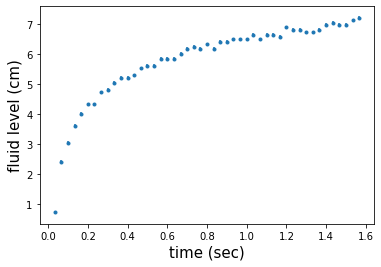

In [41]:
# plot raw data
plt.errorbar(time_data_clean[8:],z_data_clean[8:], yerr=z_err[8:], fmt='.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.show()

In [20]:
# calculate the initial starting level of the fluid in the submersed straw using fluid statics:
rho = 0.92 # mass density g/cm^3 [cite this!]
P_atm = 1030 # g/cm^2
h = 7 # cm
H = 15  # length of straw, cm
d = (1 - P_atm/(rho*h + P_atm))*H
print('fluid level will be %2.2f cm above the bottom of the straw'%(d))

fluid level will be 0.09 cm above the bottom of the straw


We define the 0th column of the array Y as as $y$, 1th column of Z as $\dot{z}$. 

$$
\vec{Z} =  \begin{pmatrix}
z\\
\dot{z}
\end{pmatrix}
$$

Then our defined function DZ_dt returns the derivatives of the array Y: 

$$
\dot{\vec{Z}}=\begin{pmatrix}
\dot{z}\\ 
\ddot{z}
\end{pmatrix}
$$
as the right hand side of our ordinary differential equation, where $\ddot{z}$ is filled in for the derived expression in the differential equation.

The function odeint from scipy can solve this for $z(t)$. 

In [38]:
# Solving the Newton's law model and also equations 17a and 17b from Lorenceau paper:


# Newton's law model
def DZ_dt_Newton(Z, t,args):
    h = args[0]
    g = args[1]
    b = args[2]
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0] ]

# Lorenceau model:
def DZ_dt_Lor(Z, t,args):
    h = args[0]
    g = args[1]
    Omeg = args[3]
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] ]


def plot_osc(h=7.0, g=9.8e2,b = 23,factor=2.60):

    # prepare data for plotting:
    z_data1 = z_data_clean[8:] # change the overall level so that bottom of straw is z=0
    time_axis1 = time_data_clean[8:]  # only include data for positive times (after cap is released)
    
    # prepare parameters for solving models:
    Omeg = 0.062*factor
    params = (h,g,b,Omeg)    
    
    # solve Newton model:
    t_soln = time_axis1
    Z_soln_Newton = sp.integrate.odeint(DZ_dt_Newton, [0.02, 0], t_soln, args=(params,))   

    z_soln_Newton = Z_soln_Newton[:,0]      # fluid height
#     ydot_soln_Newton = Y_soln_Newton[:,1]   # fluid velocity

    # solve Lorenceau model, equation 17a and 17b....
    t_solnLor = np.arange(0, 30, 0.01)
    Z_soln_Lor = sp.integrate.odeint(DZ_dt_Lor, [0.02, 0.00], t_solnLor, args=(params,))   
    
    z_soln_Lor = Z_soln_Lor[:,0]*h       # fluid height

    Omeg = 0.062*factor
    params = (h,g,b,Omeg)

    plt.clf()
    plt.plot(time_axis1,z_data1,'b.',label='Data') 
    plt.plot(t_soln,z_soln_Newton,'r',label='Newtonian model')

    plt.xlabel('time (sec)',fontsize=15)
    plt.ylabel('fluid level (cm)',fontsize=15)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)

    plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g--',label='Lorenceau model')
    plt.title('Fluid level oscillations with both models\nOmega=%2.2e (no unit), h=%2.2f, b=%2.2e\nfilename = %s'%(Omeg,h,b,filename),fontsize=15)
    plt.legend(frameon=False,loc=1)
    plt.xlim([-0.2,3])
    plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
    plt.show()


   

interact(plot_osc, h=(0.0, 20.0),g=(5.0e2, 15.0e2),b=(0.0, 30.0));


interactive(children=(FloatSlider(value=7.0, description='h', max=20.0), FloatSlider(value=980.0, description=…

*NEW* Chi-squared analysis to find the best parameters:

In [34]:
# DEFINE MODELS TO CHOOSE FROM
def damped_sin(t, *param_vals):
    return param_vals[0]*np.sin(param_vals[1]*t)*np.exp(-param_vals[2]*t )

def power_decay(t, *param_vals):
    return param_vals[0]*np.sin(param_vals[1]*t)/(t**param_vals[2])


# CHOOSE A 3-PARAMETER MODEL HERE
model_function = power_decay


initial_values = np.array([5, 11, 1]) 
deg_freedom = time_data_clean[7:].size - initial_values.size # Make sure you understand why!
print('DoF = {}'.format(deg_freedom))

popt, pcov = optimize.curve_fit(model_function, 
                       time_data_clean[8:],
                       z_data_clean[8:],
                       sigma=z_err[8:],
                       absolute_sigma=True, # Don't forget this!
                       p0=initial_values)

print('optimised parameters array popt = {}'.format(popt))

a_solution, w_solution, b_solution = popt

if model_function == damped_sin:
    print('For oscillations of the form Asin(wt)*e^(bt)')
    print('best fit A = {} '.format(a_solution))
    print('best fit w = {} '.format(w_solution))
    print('best fit b = {} '.format(b_solution))

if model_function == power_decay:
    print('For oscillations of the form Asin(wt)/(t^b)')
    print('best fit A = {} '.format(a_solution))
    print('best fit w = {} '.format(w_solution))
    print('best fit b = {} '.format(b_solution))


def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)
chisq_min = chi_squared(popt, # pass the array - no need to unpack
                        model_function, 
                        time_data_clean[8:],
                        z_data_clean[8:],
                        z_err[8:],)

print('minimised chi-squared = {}'.format(chisq_min))

chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 = {}'.format(chisq_reduced))

P_value = stats.chi2.sf(chisq_min, deg_freedom)
print('P(chi^2_min, DoF) = {}'.format(P_value))

DoF = 45
optimised parameters array popt = [10.04073017  0.72325197  0.62891517]
For oscillations of the form Asin(wt)/(t^b)
best fit A = 10.040730169702885 
best fit w = 0.7232519668631903 
best fit b = 0.6289151655816131 
minimised chi-squared = 1188.9212314607728
reduced chi^2 = 26.420471810239395
P(chi^2_min, DoF) = 1.2928952642412276e-219


The above result is exciting! Both models match data *pretty well*!!!

# Going further: examining the frequency spectrum
Our analysis so far captures most of the relevant physics. However, sometimes looking in the frequency domain can give insights that weren't readily available in time-domain analysis...

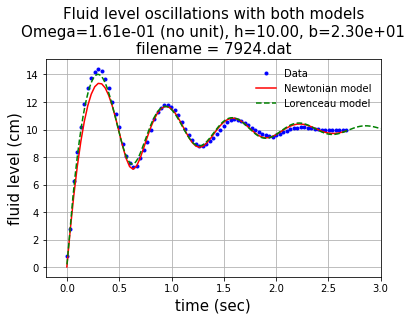

In [6]:
# define all same things as above:

h = 10
g=980
b=23
factor=2.60

# prepare data for plotting:
z_data1 = z_data_clean[8:]+h # change the overall level so that bottom of straw is z=0
time_axis1 = time_data_clean[8:]  # only include data for positive times (after cap is released)

# prepare parameters for solving models:
Omeg = 0.062*factor
params = (h,g,b,Omeg)    

# solve Newton model:
t_soln = time_axis1
Z_soln_Newton = sp.integrate.odeint(DZ_dt_Newton, [0.02, 0], t_soln, args=(params,))   

z_soln_Newton = Z_soln_Newton[:,0]      # fluid height
#     ydot_soln_Newton = Y_soln_Newton[:,1]   # fluid velocity

# solve Lorenceau model, equation 17a and 17b....
t_solnLor = np.arange(0, 300, 0.01)
Z_soln_Lor = sp.integrate.odeint(DZ_dt_Lor, [0.02, 0.00], t_solnLor, args=(params,))   

z_soln_Lor = Z_soln_Lor[:,0]*h       # fluid height

Omeg = 0.062*factor
params = (h,g,b,Omeg)

plt.clf()
plt.plot(time_axis1,z_data1,'b.',label='Data') 
plt.plot(t_soln,z_soln_Newton,'r',label='Newtonian model')

plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g--',label='Lorenceau model')
plt.title('Fluid level oscillations with both models\nOmega=%2.2e (no unit), h=%2.2f, b=%2.2e\nfilename = %s'%(Omeg,h,b,filename),fontsize=15)
plt.legend(frameon=False,loc=1)
plt.xlim([-0.2,3])
plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
plt.show()

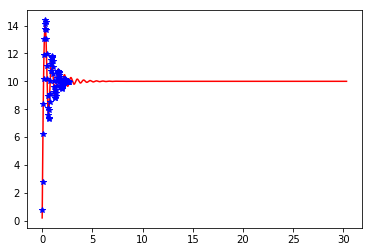

In [7]:
# plot solution for longer time so as to get denser data points in the frequency spectrum:

t_soln_sec = t_solnLor*(h*1e-2/9.8)**0.5
plt.clf()
# plt.plot(t_soln,z_soln_Newton,'r',label='ode solution')
plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'r',label='ode solution')

plt.plot(time_axis1,z_data1,'b*',label='y data') 
# plt.xlim([-.1,5])
plt.show()
z_soln = z_soln_Lor

In [8]:
# perform the discrete Fourier transform of the model which is fit to the data:

Z_FFT = np.fft.fft(z_soln-np.mean(z_soln))
z2 = Z_FFT * np.conjugate(Z_FFT)
pow = abs(z2[1:len(Z_FFT)//2] + z2[:len(Z_FFT)//2:-1])
pow = pow/np.max(pow)
DT = t_soln_sec[1]-t_soln_sec[0]   # sample time
freq = (np.fft.fftfreq(t_soln_sec.shape[0])/DT)[1:len(Z_FFT)//2]

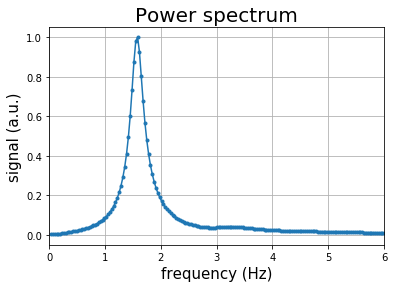

In [9]:
# check the power spectrum:

title = 'Power spectrum'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

plt.plot(freq,pow,'.-')

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=20)
plt.xlim([0,6])
# plt.savefig('power spectrum.png',dpi=400)
plt.show()

In [10]:
m = np.argmax(pow)
freq[m]

1.5839191898578666

Compare this peak value to the oscillation frequency that we can analytically derive in the limit of small oscillations:

$$ f = \frac{\omega}{2 \pi} = \frac{1}{2 \pi} \left ( \frac{g}{h} \right )^{1/2}$$

In [11]:
h_guess = 10 # cm

In [12]:
f_est = 1/(2*np.pi)*np.sqrt(g/h_guess)
print('small oscillation frequency = %2.3f Hz'%(f_est))

small oscillation frequency = 1.576 Hz


Fit the power spectrum with a Lorentzian function:

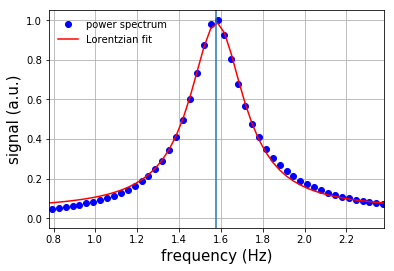

In [13]:
def Lorentzian(x_val, h, w, x_c, y_0):
    return ((h * w**2)/((w**2)+(4*(x_val - x_c)**2)) + y_0)
h_g   = 1    #h = height
w_g   = 1        #w = fwhm
x_c_g = 1.5        #x_c = x val of peak
y_0_g = 0           #y_0 = y val of asymptote

fit_from_Hz = 0.5
fit_to_Hz = 2.5

fit_from_Hz = 1
fit_to_Hz = 2.5

fit_from = int(np.round(np.interp(fit_from_Hz,freq,np.arange(len(freq)))))
fit_to = int(np.round(np.interp(fit_to_Hz,freq,np.arange(len(freq)))))



#best fit lines (guesses help the process)
p_guess = [h_g, w_g, x_c_g, y_0_g]
peak, pcov = sp.optimize.curve_fit(Lorentzian, freq[fit_from:fit_to],pow[fit_from:fit_to], p0 = p_guess)

perr = np.sqrt(np.diag(pcov))
plt.plot(freq[:100],pow[:100],'bo',label = 'power spectrum')
# plt.plot(freq[:100], Lorentzian(freq[:100], *p_guess), 'g--',label='guess')
plt.plot(freq[:100], Lorentzian(freq[:100], *peak), 'r',label='Lorentzian fit')
plt.grid()

plt.axvline(x=f_est)
# plt.axvline(x=fit_to_Hz)
wdith_plot = 0.8
plt.xlim([peak[2]-wdith_plot,peak[2]+wdith_plot])
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'
plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.legend(frameon=False,loc=2) 
plt.savefig('fig3 - frequency spectrum.png',dpi=400)
plt.show()

In [14]:
print("Our fitted values using Lorentzian model:")
print("Height: %.9f"%(peak[0]),"a.u.")
print("FWHM : %.5f"%(peak[1]),"Hz")
print("Center: x =%.5f"%(peak[2]),"Hz")
print("Flatline: y =%.9f"%(peak[3]),"a.u.")
print()

Our fitted values using Lorentzian model:
Height: 0.944335219 a.u.
FWHM : 0.31352 Hz
Center: x =1.57944 Hz
Flatline: y =0.042939149 a.u.



In [15]:
# the width of the power spectrum gives an estimate of the timescale of the decay:

FWHM = peak[1]
DT = 1/(FWHM)
print('The width of the power spectrum is %2.2f Hz which implies a decay time of DT=%2.2e sec'%(FWHM,DT))

The width of the power spectrum is 0.31 Hz which implies a decay time of DT=3.19e+00 sec


In [16]:
print('discrepancy bw small oscillations and measured peak is %2.2f %%'%((f_est - peak[2])/f_est*100))

discrepancy bw small oscillations and measured peak is -0.25 %


# Further considerations:

Considering the viscosity of water -- 
If the time scale of motion is happening faster than a characteristic time scale given by T = (2nd page, 2nd paragraph of Lorenceau paper):

$$ \rho R^2/\eta$$

then it is not needed to include viscous dissipation along the walls of the tube. 

In [17]:
eta = 1.002e-3 # Pa*sec
rho = 1000 # kg/m^3
R = 0.005 # meters

In [18]:
timescale = rho* R**2/eta
timescale

24.9500998003992

25 seconds -- indeed, no need to worry about dissipation along the walls of the tube. Then it is all about the singular pressure loss at the tube opening at the bottom as eddies appear, dissipating energy

https://www.saylor.org/site/wp-content/uploads/2011/04/Viscosity.pdf


https://en.wikipedia.org/wiki/Laminar_flow

Also, we can calculate the kinematic viscosity of water, yeilding the Reynolds number:



In [19]:
mu = 8.9e-4 # Pa*sec @ 25 deg C   
rho = 1000 # kg/m^3 density of water
nu =  mu/rho   # ν is the kinematic viscosity of the fluid, ν = (m2/s);
D = 10.8e-3    # DH is the hydraulic diameter of the pipe (m);
vymax = 0.2 # m/s  -- this is an estimate of the peak velocity, just from looking at the data.

Re = vymax *D/nu

print('Reynolds # = %2.2f'%(Re))

Reynolds # = 2426.97


This Reynolds number is in an in-between the laminar and turbulent flow regimes at the very beginning, which may explain the discrepancy between the experimental data and the models. Both models assume a laminar flow regime, where linear 'channels' of water flow do not cross over each other. The remaining flow, with lower velocities, is in the laminar flow regime.

In [20]:
# calculation of omega factor in Lorenceau, Eqn. 16.
omeg = 16*eta*(9.2e-2)**0.5/(rho*(0.010/2)**2 * 9.8**0.5)
omeg
# units check out to be unitless

0.0621338938796939